In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def rank_genes_groups_to_df(adata, cell):
    
    dic = adata.uns['rank_genes_groups'] 
    
    df = pd.DataFrame({
        'names' : dic['names'][cell],
        'scores' : dic['scores'][cell],
        'pvals' : dic['pvals'][cell],
        'pvals_adj' : dic['pvals_adj'][cell],
        'logfoldchanges' : dic['logfoldchanges'][cell]
    })
    
    return df

# rank_genes_groups_to_df(sanp, 'SAN_P_cell')

In [14]:
sc.settings.set_figure_params(dpi=300)

# Read in

In [4]:
# post ArchR-QC
# only Multiome
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/ArchR/project_output/GeneScoreMatrix/Adult_GeneScores.h5ad')
adata

AnnData object with n_obs × n_vars = 139835 × 24919
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'batch_key', 'cell_type', 'cell_state'

In [5]:
adata.obs['cell_type'].cat.reorder_categories([
   'Atrial Cardiomyocyte', 
    'Ventricular Cardiomyocyte',
    'Fibroblast',
    'Endothelial cell', 
    'Lymphatic Endothelial cell',
    'Mural cell',
    'Mesothelial cell',
     'Neural cell',
    'Adipocyte', 
    'Myeloid',
        'Lymphoid', 
    'Mast cell',
     ], inplace=True)

# Differentially scored genes

## Cell type

In [6]:
adata.obs['cell_type'].value_counts()

Fibroblast                    42479
Ventricular Cardiomyocyte     35284
Endothelial cell              16104
Atrial Cardiomyocyte          14163
Myeloid                       13660
Mural cell                    10121
Lymphoid                       4399
Neural cell                    1581
Adipocyte                      1374
Lymphatic Endothelial cell      334
Mast cell                       274
Mesothelial cell                 62
Name: cell_type, dtype: int64

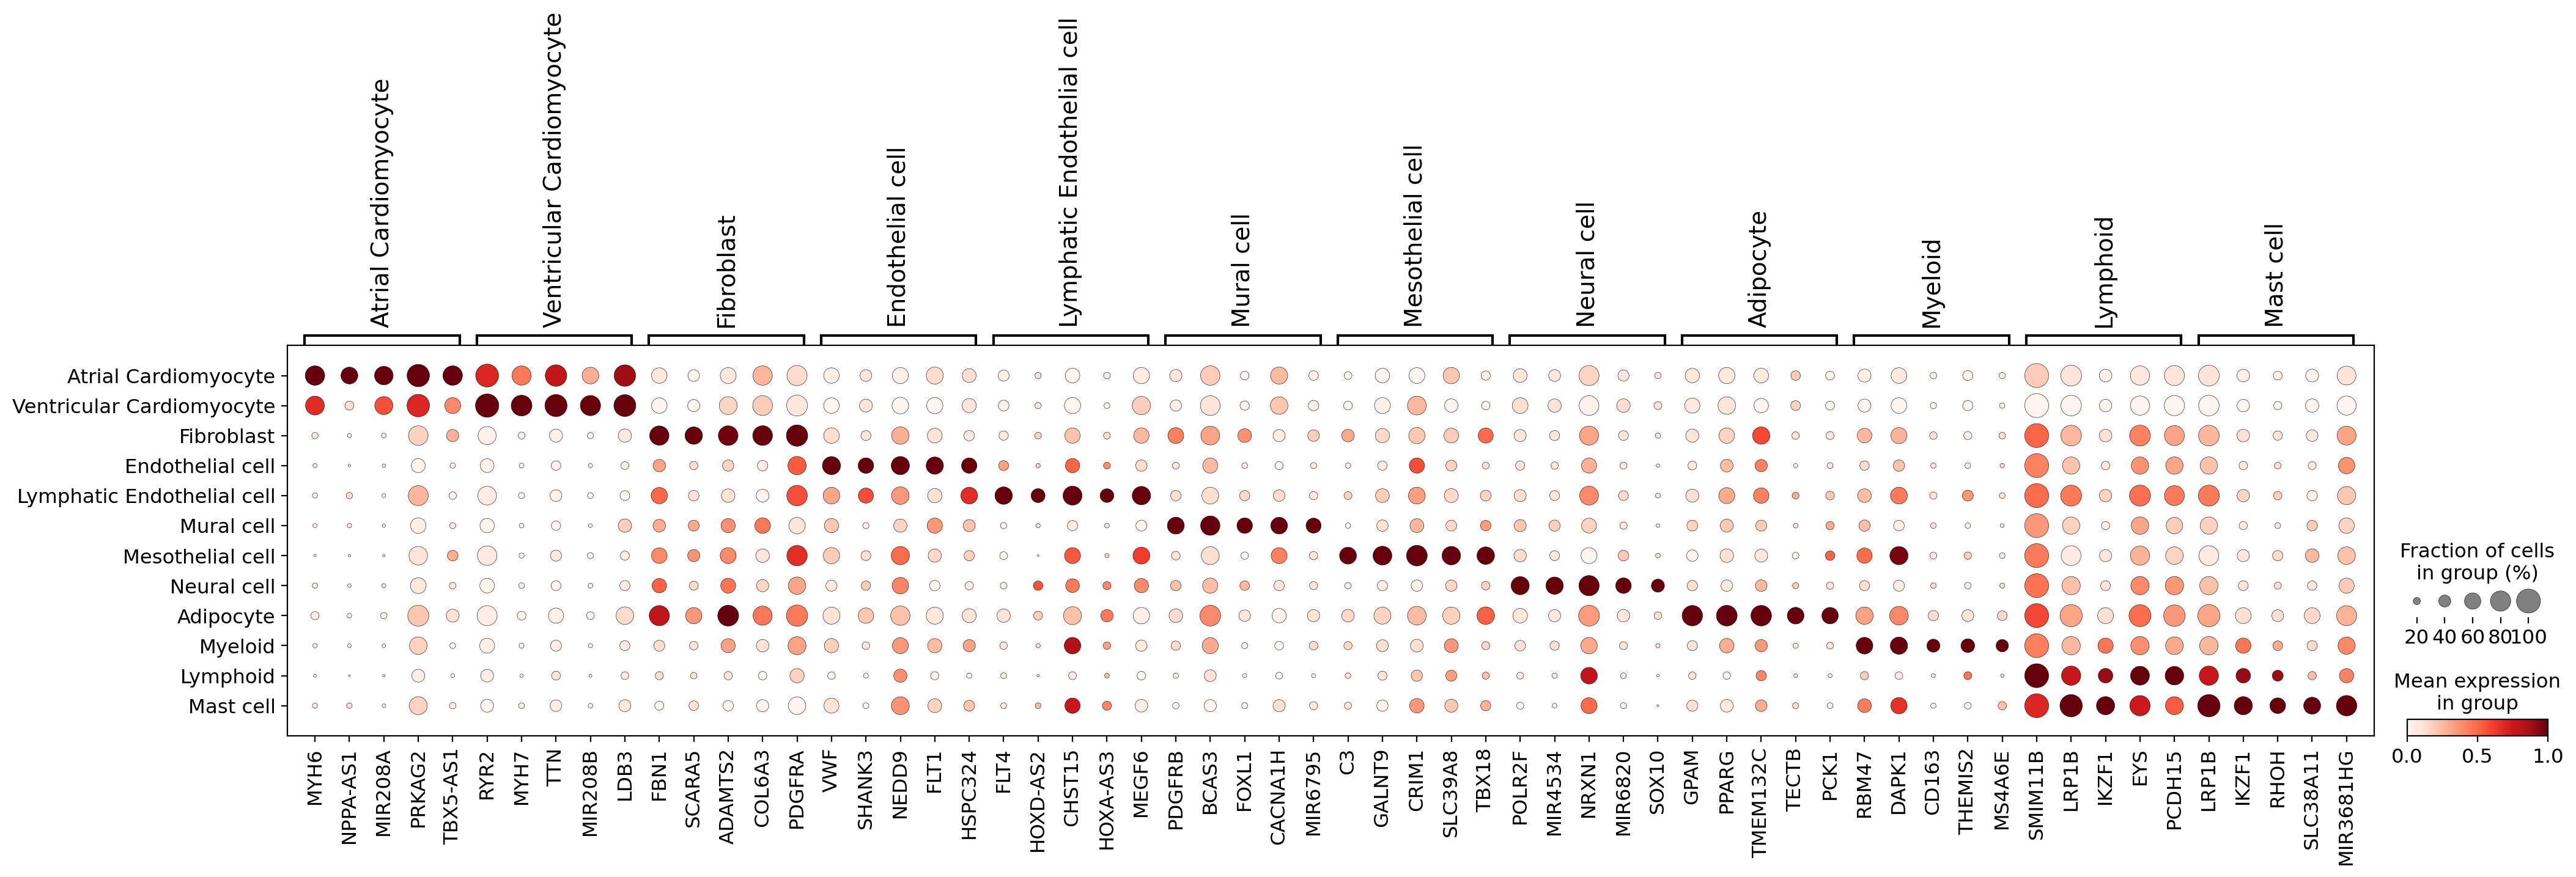

In [7]:
# rank test
sc.tl.rank_genes_groups(adata, 'cell_type', method='wilcoxon')

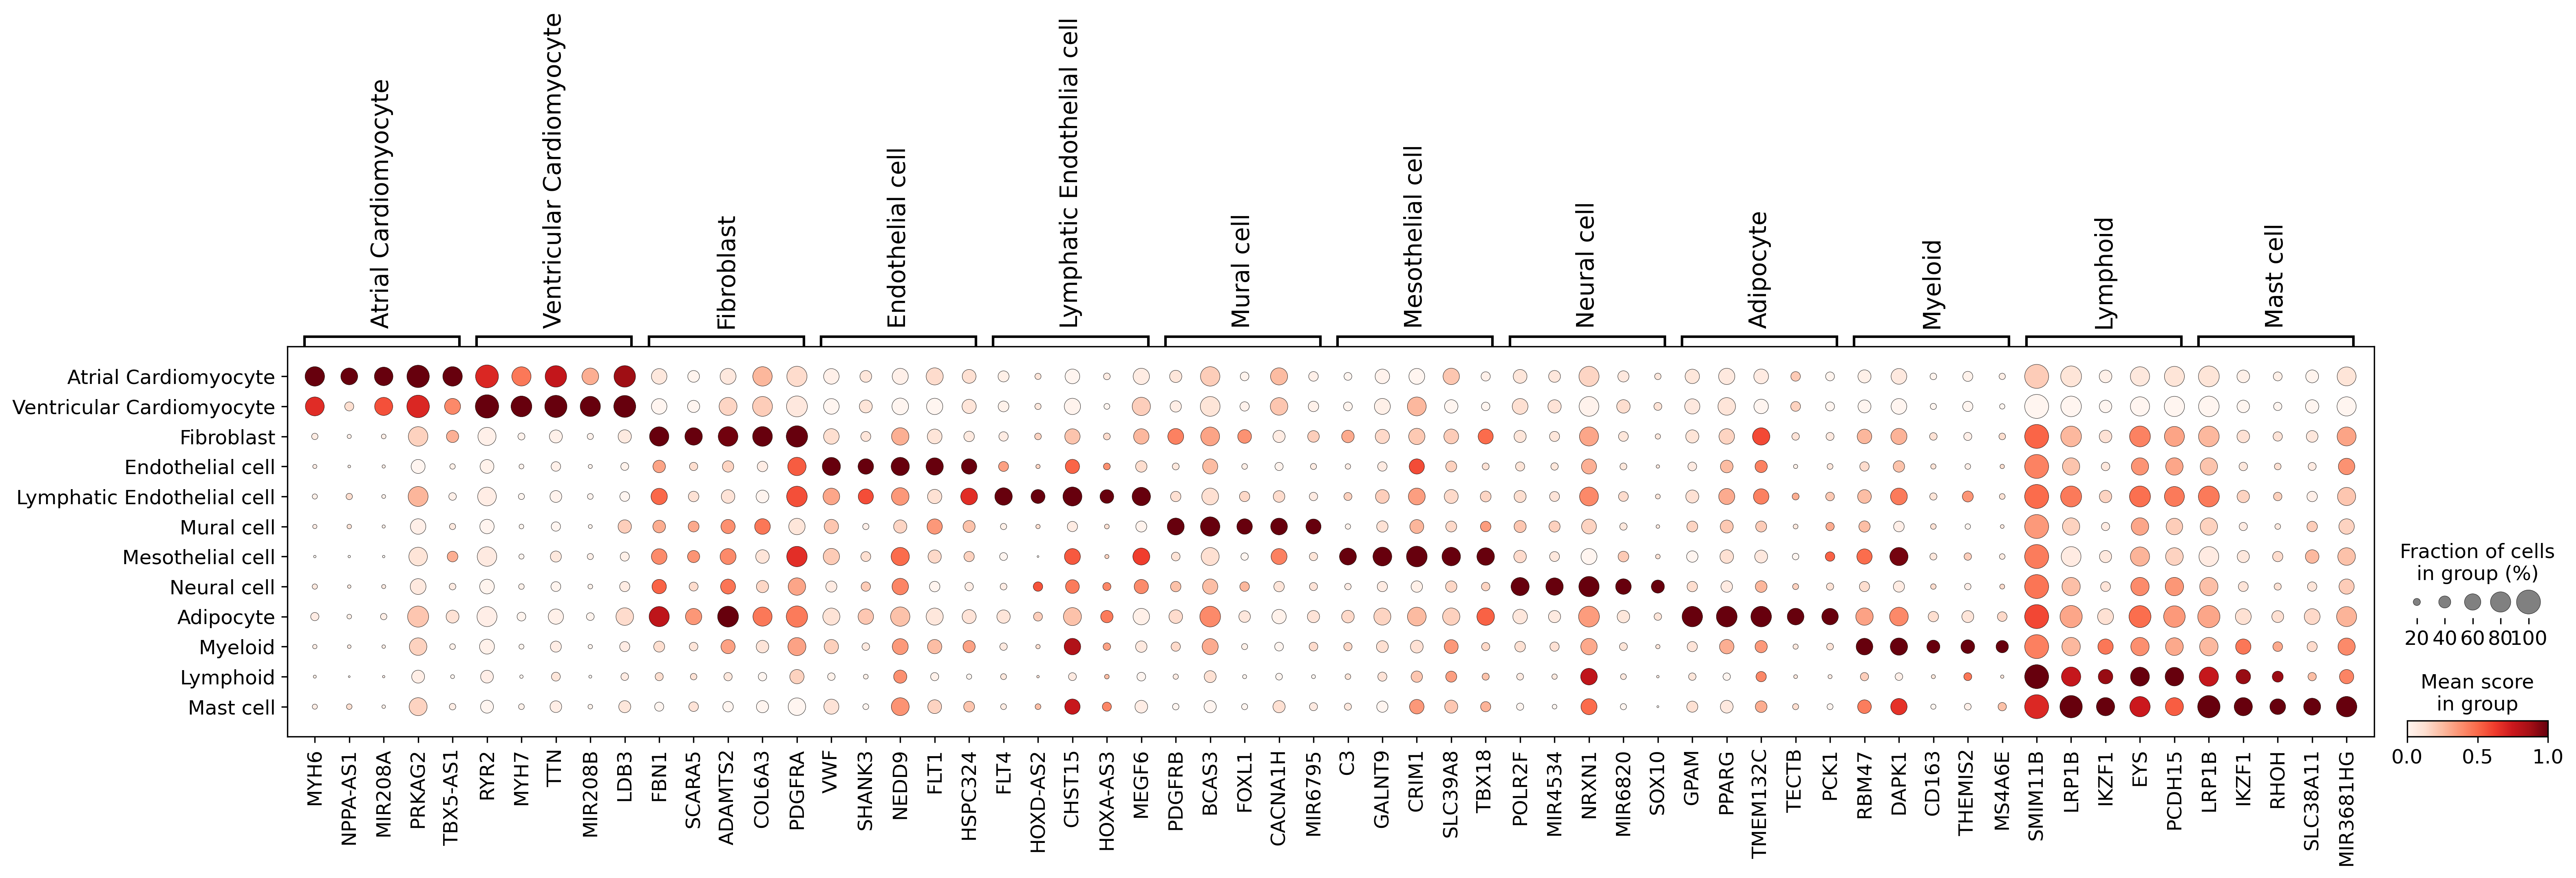

In [15]:
# plot differential gene scores
sc.pl.rank_genes_groups_dotplot(adata, swap_axes=False, dendrogram=False, n_genes=5, standard_scale='var',
                               colorbar_title='Mean score\nin group',)

## SAN_P vs AVN_P vs AtrialCM

In [8]:
# collect CCS cells
adata_sub = adata[adata.obs['cell_state'].isin(['aCM1','aCM2','aCM3','aCM4','aCM5',
                                          'vCM1','vCM2','vCM3_stressed','vCM4','vCM5',
                                                 'SAN_P_cell','AVN_P_cell','AVN_bundle_cell','Purkinje_cell'])]


sanp_barcode = adata_sub.obs_names[adata_sub.obs['cell_state']=='SAN_P_cell']
avnp_barcode = adata_sub.obs_names[adata_sub.obs['cell_state']=='AVN_P_cell']
avnbundle_barcode = adata_sub.obs_names[adata_sub.obs['cell_state']=='AVN_bundle_cell']
purkinje_barcode = adata_sub.obs_names[adata_sub.obs['cell_state']=='Purkinje_cell']

adata_sub.obs['cell_type_withCCS']=adata.obs['cell_type'].astype('str')
adata_sub.obs.loc[sanp_barcode,'cell_type_withCCS']=adata_sub.obs.loc[sanp_barcode,'cell_state']
adata_sub.obs.loc[avnp_barcode,'cell_type_withCCS']=adata_sub.obs.loc[avnp_barcode,'cell_state']
adata_sub.obs.loc[avnbundle_barcode,'cell_type_withCCS']=adata_sub.obs.loc[avnbundle_barcode,'cell_state']
adata_sub.obs.loc[purkinje_barcode,'cell_type_withCCS']=adata_sub.obs.loc[purkinje_barcode,'cell_state']

adata_sub.obs['cell_type_withCCS']=adata_sub.obs['cell_type_withCCS'].astype('category')
adata_sub.obs['cell_type_withCCS'].cat.reorder_categories([
    'SAN_P_cell','AVN_P_cell','AVN_bundle_cell',
    'Atrial Cardiomyocyte',
    'Purkinje_cell','Ventricular Cardiomyocyte'
     ], inplace=True)

adata_sub.obs['cell_type_withCCS'].value_counts()

Trying to set attribute `.obs` of view, copying.


Ventricular Cardiomyocyte    35271
Atrial Cardiomyocyte         13877
SAN_P_cell                     169
AVN_P_cell                      91
AVN_bundle_cell                 26
Purkinje_cell                   13
Name: cell_type_withCCS, dtype: int64

Trying to set attribute `.uns` of view, copying.


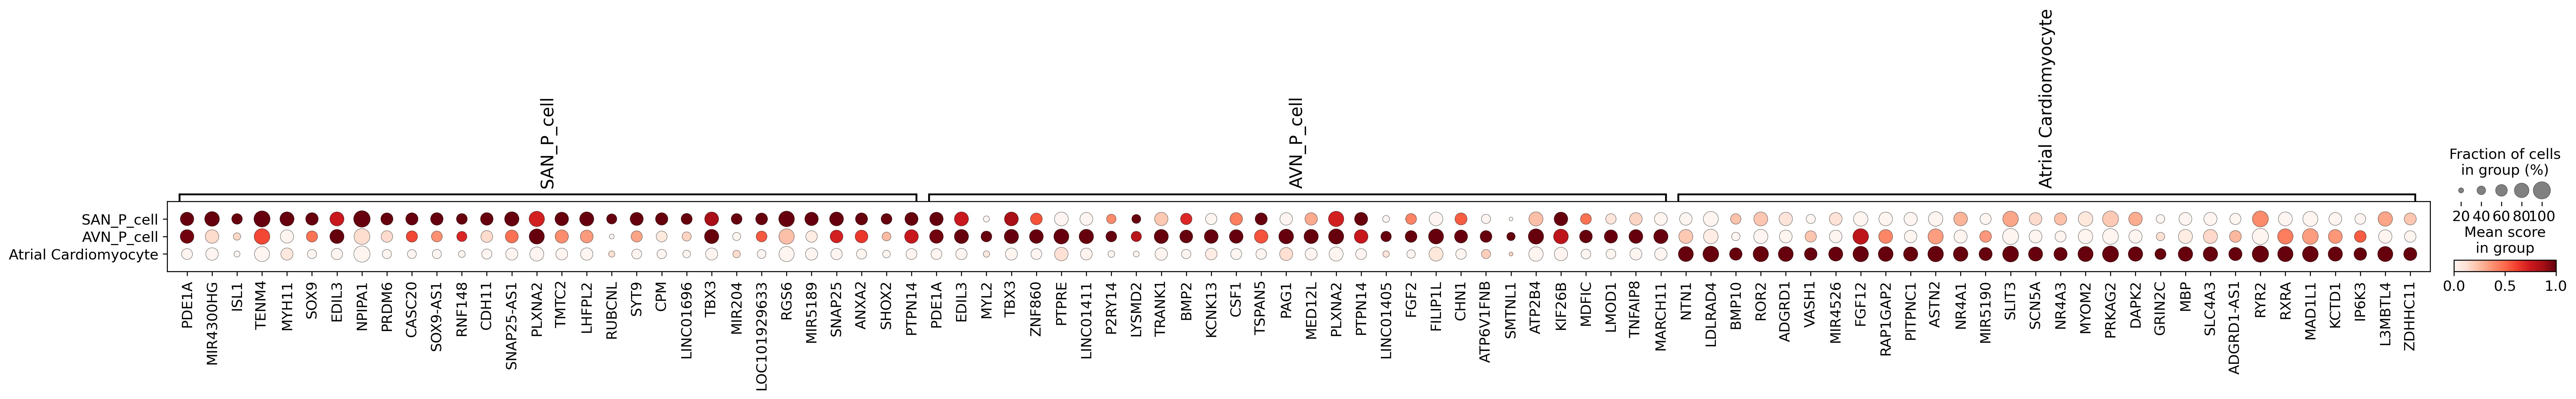

In [18]:
# remove low number cells
adata_sub = adata_sub[adata_sub.obs['cell_type_withCCS'].isin(['AVN_bundle_cell','Purkinje_cell','Ventricular Cardiomyocyte'])==False]

# rank test
sc.tl.rank_genes_groups(adata_sub, 'cell_type_withCCS', method='wilcoxon')

# plot differential gene scores
sc.pl.rank_genes_groups_dotplot(adata_sub, swap_axes=False, dendrogram=False, n_genes=30, standard_scale='var',
                               colorbar_title='Mean score\nin group')

In [19]:
markers = {'TF':['TBX3','SHOX2','ISL1','TBX18','TBX5'],
 'Ion channel':['HCN1','HCN4','CACNA1D','CACNA1G','CACNA2D2','CACNB4',
                'SCN5A','KCNJ3','KCNJ5','KCND2','KCNK1','KCNK13',
               'GJA1','GJA5','GJC1']}

In [20]:
df = rank_genes_groups_to_df(adata_sub, 'SAN_P_cell')
df = df[(df['pvals_adj']<0.05)&(df['logfoldchanges']>0)]
san_genes = list(df['names'])
print(len(san_genes))

df = rank_genes_groups_to_df(adata_sub, 'AVN_P_cell')
df = df[(df['pvals_adj']<0.05)&(df['logfoldchanges']>0)]
avn_genes = list(df['names'])
print(len(avn_genes))

genes = san_genes + avn_genes
print(len(genes))

for k,v in markers.items():
    updated = [x for x in v if x in genes]
    markers[k] = updated.copy()
markers

424
52
476


{'TF': ['TBX3', 'SHOX2', 'ISL1'],
 'Ion channel': ['CACNA1D', 'CACNA2D2', 'KCNK13']}

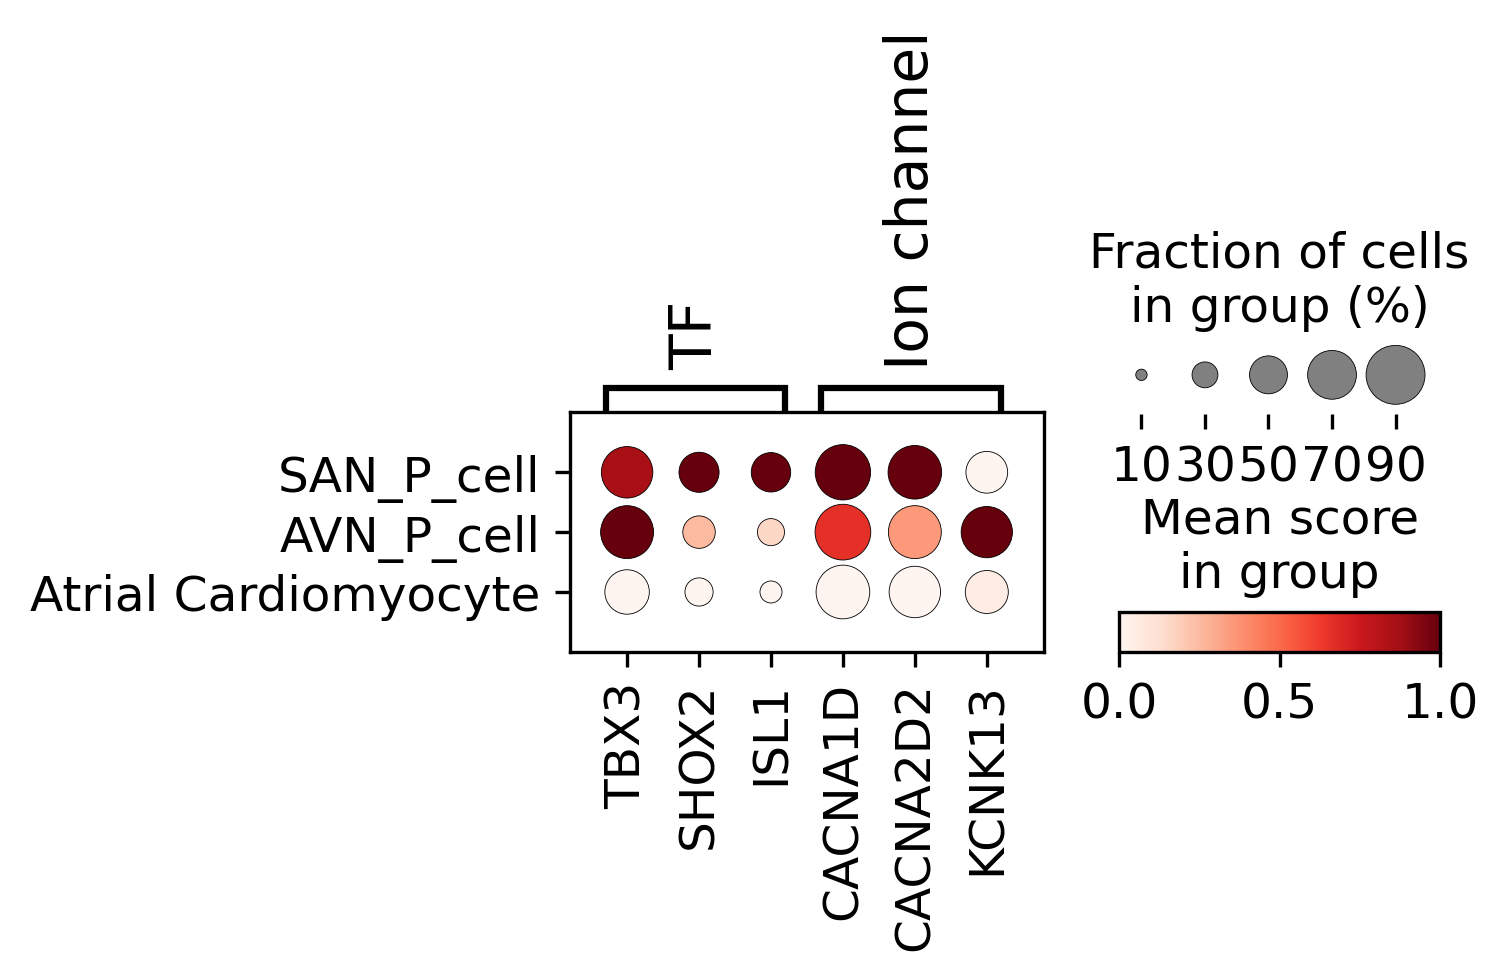

In [21]:
sc.pl.dotplot(adata_sub, 
              markers, 
              groupby='cell_type_withCCS',
              dendrogram=False,
              # use_raw=True,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
              colorbar_title='Mean score\nin group'
             # title='Neurexin receptors'
             )

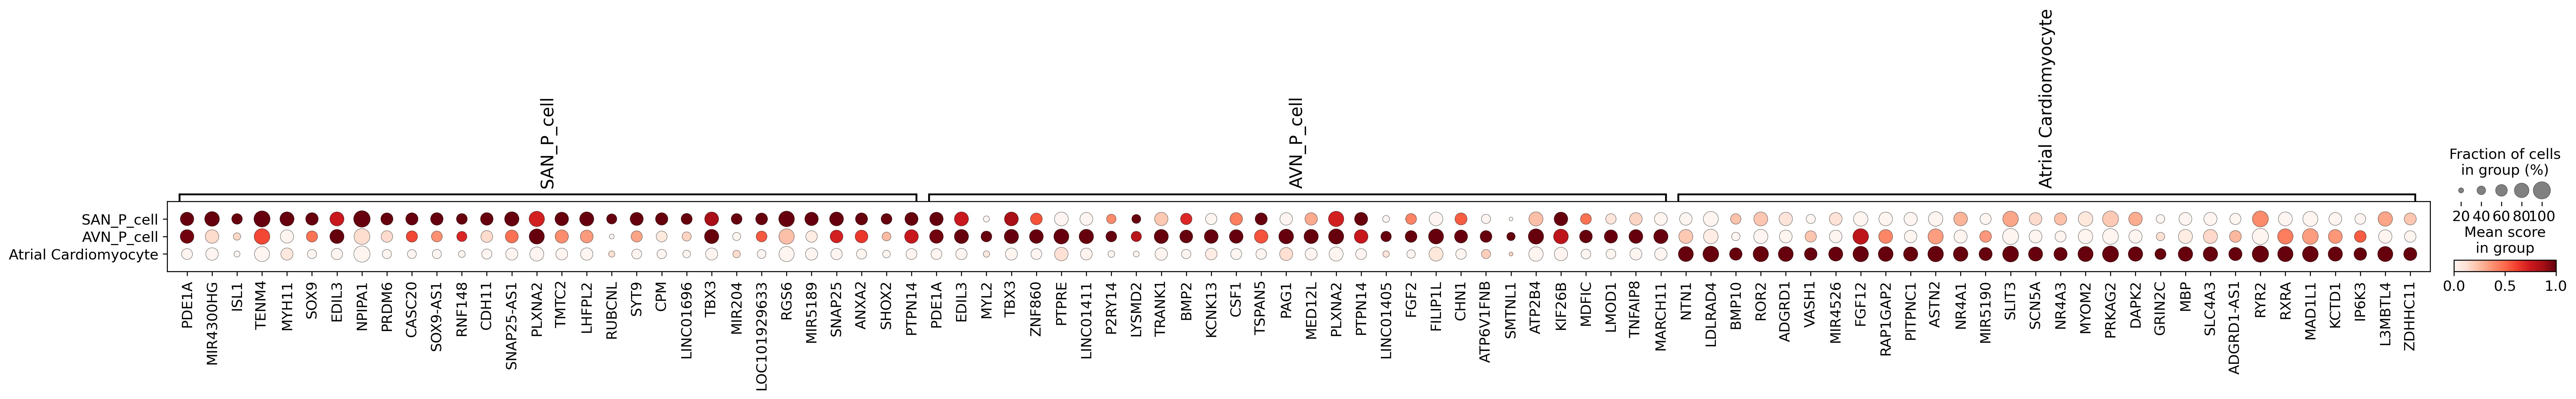

In [22]:
# plot differential gene scores
sc.pl.rank_genes_groups_dotplot(adata_sub, swap_axes=False, dendrogram=False, n_genes=30, standard_scale='var',
                               colorbar_title='Mean score\nin group')

## vCM3 vs vCMs

Trying to set attribute `.uns` of view, copying.


vCM4             14057
vCM1             13484
vCM2              3980
vCM3_stressed     3750
Name: cell_state, dtype: int64


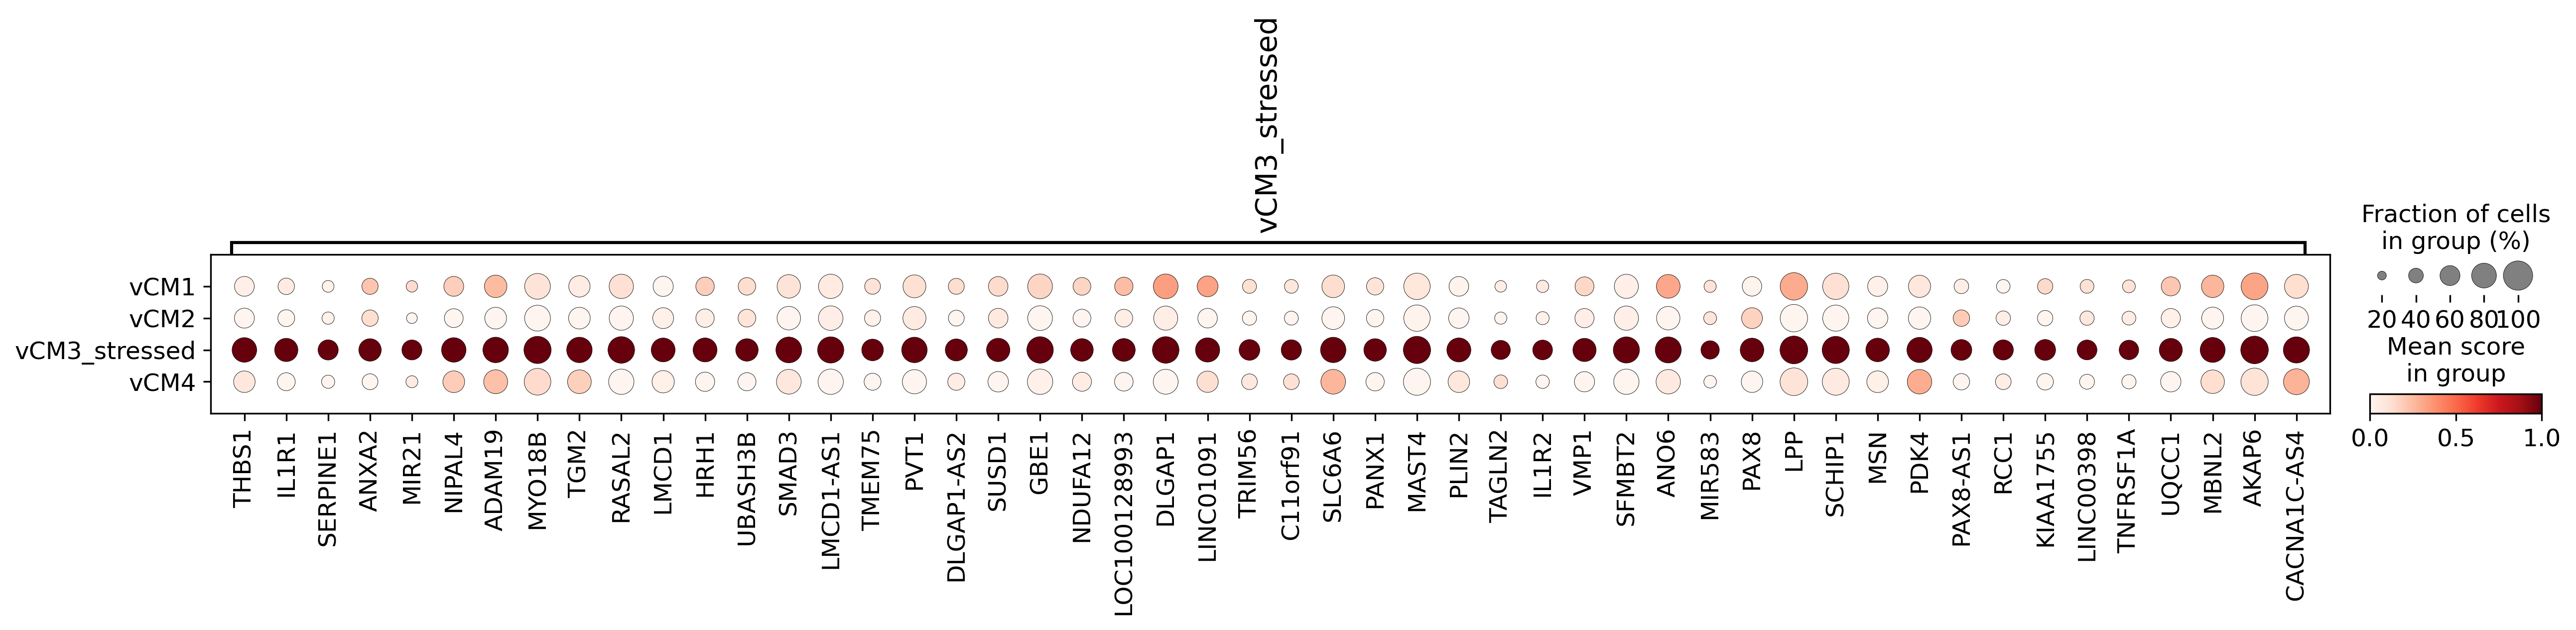

In [23]:
target = 'vCM3_stressed'
reference = ['vCM1','vCM2','vCM3_stressed','vCM4','vCM5']
n_genes = 50

# rank test
adata_sub = adata[adata.obs['cell_state'].isin(reference)]
print(adata_sub.obs['cell_state'].value_counts())

sc.tl.rank_genes_groups(adata_sub, 'cell_state', groups=[target], reference='rest', method='wilcoxon')

# plot differential gene scores
sc.pl.rank_genes_groups_dotplot(adata_sub, swap_axes=False, dendrogram=False, n_genes=n_genes, standard_scale='var',colorbar_title='Mean score\nin group')

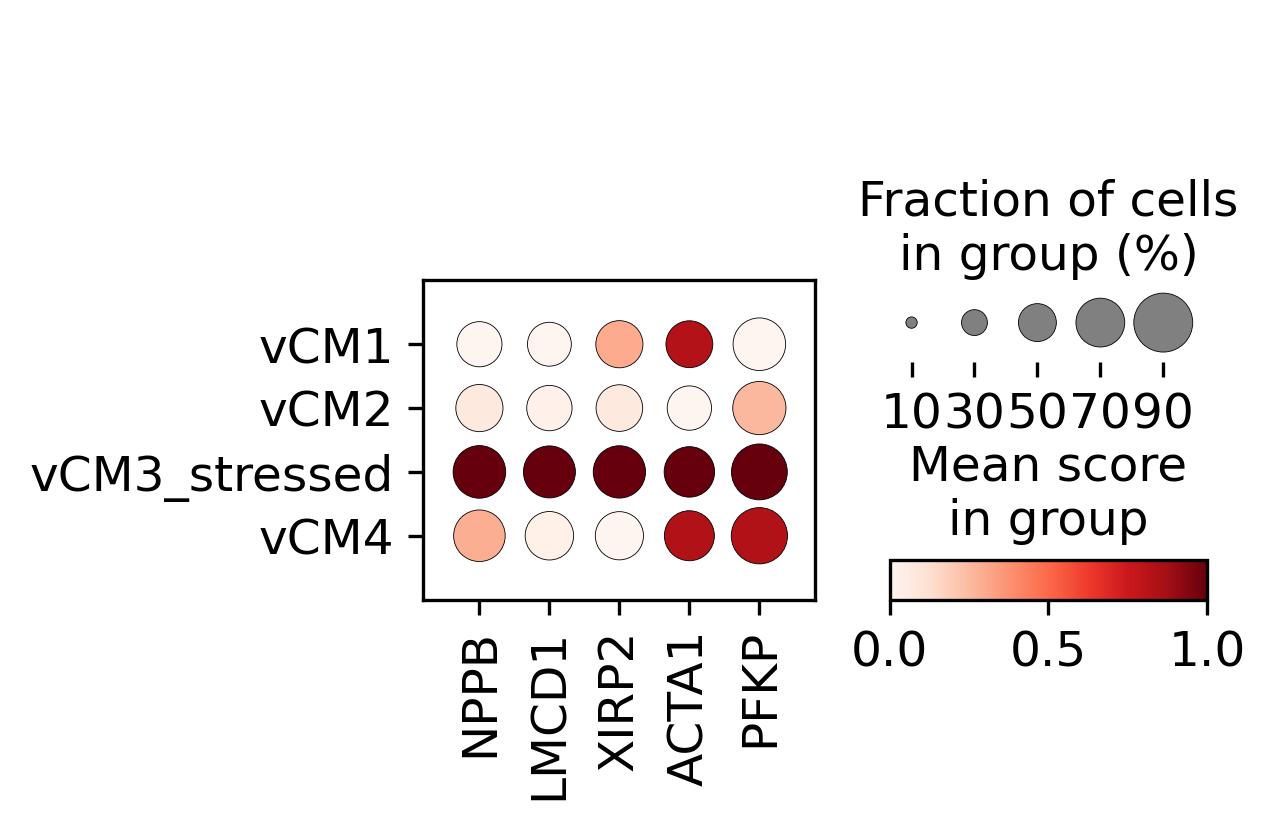

In [25]:
target = 'vCM3_stressed'
reference = ['vCM1','vCM2','vCM3_stressed','vCM4','vCM5']
n_genes = 50

# rank test
adata_sub = adata[adata.obs['cell_state'].isin(reference)]

markers= ['NPPB','LMCD1','XIRP2','ACTA1','PFKP']

sc.pl.dotplot(
               adata_sub, 
              markers, 
              groupby='cell_state',
              dendrogram=False,
              # use_raw=True,
              standard_scale="var",
              color_map="Reds",
             swap_axes=False,
    colorbar_title='Mean score\nin group'
              # return_fig=True,
             # title='Neurexin receptors'
             )